<h1>Portfolio Optimization with Regulization</h1>

<p style='text-align: justify'>This project aims to optimize a portfolio using the minimum variance portfolio, while incorporating regularization techniques. The regularization method used is L1 (Lasso) regression, which promotes sparsity by adding a penalty term to the loss function. The code is based on the paper <a href='https://www.ecb.europa.eu/pub/pdf/scpwps/ecbwp936.pdf'>Sparse and stable Markowitz portfolios</a> published by Joshua Bordie, Ingrid Daubechies, Christine De Mol, Domenico Giannone and Ignace Loris.</p>

<h2>Part I - Implementing necessary functions</h2>

<h3>Import required packages</h3>

In [2]:
# Data source and manipulation
import pandas_datareader
import pandas as pd

# Checking for stationarity
from statsmodels.tsa.stattools import adfuller

# Mathematical operations and optimizations
import cvxpy as cp 
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# Ignore warnings
from warnings import filterwarnings
filterwarnings('ignore')

<h3>Receiving Data</h3>
The projects utilizes historic returns from portfolios provided by the Fama/French database. The pandas data reader is used to make the necessary API calls to receive data from the online database.

In [3]:
def get_available_fama_french_datasets() -> list[str]:
    """
    This function retrieves a list of available datasets from the Fama/French database.
    
    Parameters:
    None
    
    Returns:
    list[str]: A list of strings representing the available datasets.
    """
    return pandas_datareader.famafrench.get_available_datasets()

def get_fama_french_data(dataset_name: str, start: str = None, end: str = None, print_description: bool = False) -> pd.DataFrame:
    """
    This function retrieves and processes data from the Fama/French database. For further information check the documentation at:
    https://pandas-datareader.readthedocs.io/en/latest/readers/famafrench.html. 
    
    Parameters:
    dataset_name (str): The name of the dataset to retrieve.
    start (str, optional): The start date for the data retrieval.
    end (str, optional): The end date for the data retrieval. If not provided, data will end at the latest available date.
    print_description (bool, optional): If True, the function will print the description of the dataset. Default is False.
    
    Returns:
    pd.DataFrame: A pandas DataFrame containing the retrieved data. If an error occurs during retrieval or processing, the function returns None.
    """
    # Try to download the specified dataset from the fama french database
    try:
        data: dict = pandas_datareader.famafrench.FamaFrenchReader(dataset_name, start=start, end=end).read()
    except Exception as e:
        print(f"Error fetching data for dataset '{dataset_name}': {str(e)}")
        return None
    
    # Print dataset description if requested
    try:
        if print_description:
            print(data['DESCR'])
    except KeyError as e:
        print(f"No dataset description found for dataset '{dataset_name}'")
    
    # Return the DataFrame from the loaded dataset
    try:
        return data[0]
    except KeyError as e:
        print(f"No DataFrame found for dataset '{dataset_name}'")
        return None
    
def convert_percentage_to_decimal(dataset: pd.DataFrame) -> pd.DataFrame:
    """
    This function converts the percentage values in a pandas DataFrame to decimal form.
    
    Parameters:
    dataset (pd.DataFrame): The DataFrame containing the percentage values. The DataFrame should have column names.
    
    Returns:
    pd.DataFrame: The DataFrame with the percentage values converted to decimal form. If a TypeError occurs during the conversion,
    the function prints an error message and returns the original DataFrame.
    """
    for col in dataset.columns:
        try:
            dataset[col] = dataset[col] / 100
        except TypeError as e:
            print(f"Unable to convert column '{col}' to decimal: {e}")
    return dataset

<h3>Download the data for a portfolio consisting of sub portfolios representing 48 industries</h3>

In [4]:
data: pd.DataFrame = get_fama_french_data(dataset_name='48_Industry_Portfolios_daily')
data: pd.DataFrame = convert_percentage_to_decimal(data)
data.head()

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-04,0.0332,0.0404,0.0526,0.0443,0.0573,0.0283,0.0290,0.0212,0.0483,0.0329,...,0.0319,0.0392,0.0320,0.0378,0.0292,0.0301,0.0728,0.0259,0.0235,0.0408
2020-03-05,-0.0488,-0.0167,-0.0340,-0.0249,-0.0129,-0.0374,-0.0472,-0.0413,-0.0252,-0.0393,...,-0.0316,-0.0517,-0.0350,-0.0247,-0.0506,-0.0481,-0.0342,-0.0424,-0.0424,-0.0410
2020-03-06,-0.0627,-0.0133,-0.0237,-0.0079,-0.0129,-0.0348,-0.0099,0.0008,-0.0035,-0.0182,...,-0.0163,-0.0022,-0.0213,-0.0083,-0.0036,-0.0335,-0.0139,-0.0330,-0.0297,-0.0169
2020-03-09,-0.0843,-0.0454,-0.0618,-0.0592,-0.0567,-0.0849,-0.0833,-0.0796,-0.0494,-0.0716,...,-0.0744,-0.0964,-0.0791,-0.0446,-0.0643,-0.1193,-0.0750,-0.1013,-0.0892,-0.0702
2020-03-10,0.1061,0.0205,0.0397,0.0231,0.0405,0.0181,0.0614,0.0490,0.0365,0.0441,...,0.0339,0.0535,0.0416,0.0431,0.0561,0.0686,0.0446,0.0508,0.0535,0.0476


<h3>Check for stationarity</h3>

In [5]:
def check_stationarity(dataset: pd.DataFrame, critical_value: float = 0.05, verbose: bool = True, return_result: bool = False) -> None | list[bool]:
    """
    This function checks the stationarity of each column in a given pandas DataFrame using the Augmented Dickey-Fuller (ADF) test.
    
    Parameters:
    dataset (pd.DataFrame): The DataFrame containing the time series data. Each column represents a different time series.
    critical_value (float, optional): The critical value for the ADF test. If the p-value is less than this value, the time series is considered stationary. Default is 0.05.
    verbose (bool, optional): If True, the function will print a message for each non-stationary column. Default is True.
    return_result (bool, optional): If True, the function will return a list of boolean values indicating the stationarity of each column. Default is False.
    
    Returns:
    None: If return_result is False and all columns are stationary.
    list[bool]: A list of boolean values indicating the stationarity of each column. If return_result is True.
    """
    result: list[bool] = []
    for col in dataset.columns:
        try:
            dftest = adfuller(dataset[col], autolag='AIC')
            stationary: bool = dftest[1] < critical_value
            if verbose and not stationary:
                print(f"Column '{col}' is not stationary (p-value: {dftest[1]:.4f})")
            result.append(stationary)
        except Exception as e:
            print(f"Unable to check stationarity for column '{col}': {e}")
    
    if False not in result:
        print("All columns in the dataset are stationary.")
    
    if return_result:
        return result

check_stationarity(data)

All columns in the dataset are stationary.


<h3>Function for finding the minimum variance portfolio (MVP) without regularization</h3>


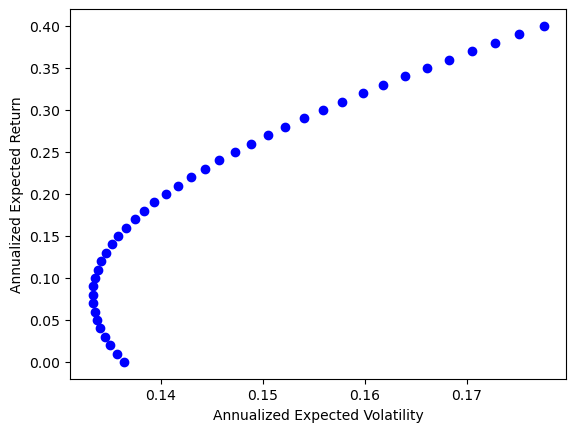

In [ ]:
def minimum_variance_without_regularization(returns: pd.DataFrame, min_expected_return: float = 0.1, days_per_year: int = 252, verbose: bool = False) -> tuple[np.array, float]:
    """
    This function calculates the minimum variance portfolio without regularization.

    Parameters:
    returns (pd.DataFrame): A pandas DataFrame containing the daily returns of the assets in the portfolio. Each column represents an asset.
    min_expected_return (float, optional): The minimum expected yearly return for the portfolio. Default is 0.1 (10%).
    days_per_year (int, optional): The number of trading days in a year. Default is 252 (assuming a trading year of 252 days).
    verbose (bool, optional): If True, the function will print optimization progress. Default is False.

    Returns:
    tuple[np.array, float]: A tuple containing the optimal weights for each asset in the portfolio (as a numpy array) and the corresponding minimum risk (annualized).
    """
    observations: int = returns.shape[0]
    num_assets: int = returns.shape[1]
    
    # Convert minimum expected yearly return to daily return
    min_daily_return: float = min_expected_return / days_per_year
    
    # Compute mean daily returns and covariance matrix
    mean_returns: np.array = returns.mean().values  # Expected daily returns
    cov_matrix: np.array = returns.cov().values    # Covariance matrix of returns
    
    # Define optimization variables
    weights: cp.Variable = cp.Variable(num_assets)
        
    # Define objective function (minimize portfolio variance)
    objective = cp.Minimize(weights.T @ cov_matrix @ weights)
    # The objective function could also be written as:
    # objective = cp.Minimize((1/observations) * cp.sum_squares(min_daily_return * np.ones(observations) - returns.values @ weights))
    
    # Define constraints
    constraints = [
        cp.sum(weights) == 1,  # Weights must sum to 1 | fully invested portfolio
        # weights >= 0,  # No short-selling constraint
        mean_returns @ weights == min_daily_return  # Minimum expected return constraint
    ]
    
    # Solve the optimization problem
    problem = cp.Problem(objective, constraints)
    problem.solve(verbose=verbose)
    
    min_risk_annualized = np.sqrt(problem.value * 252)
    
    # Return the optimal weights
    return weights.value, min_risk_annualized

# Show the minimum variance portfolios for different minimum expected returns
expected_returns: list[float] = [r / 100 for r in range(41)]
risks_to_take: list[float] = [minimum_variance_without_regularization(data, min_expected_return=r)[1] for r in expected_returns]

fig = plt.figure()
ax = fig.add_subplot()
ax.set_xlabel('Annualized Expected Volatility')
ax.set_ylabel('Annualized Expected Return')
plt.scatter(risks_to_take, expected_returns, color='b')
pass

<h3>Function for finding the minimum variance portfolio (MVP) including L1 regularization</h3>

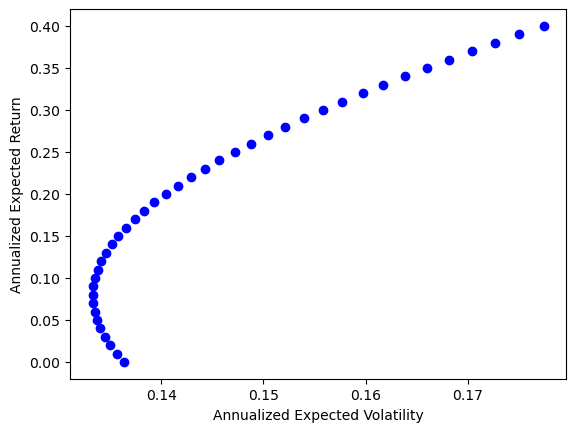

In [12]:
def minimum_variance_with_regularization(returns: pd.DataFrame, min_expected_return: float = 0.1, days_per_year: int = 252, tau: float = 0.0, verbose: bool = False) -> tuple[np.array, float]:
    """
    This function calculates the minimum variance portfolio with L1 regularization.

    Parameters:
    returns (pd.DataFrame): A pandas DataFrame containing the daily returns of the assets in the portfolio. Each column represents an asset.
    min_expected_return (float, optional): The minimum expected yearly return for the portfolio. Default is 0.1 (10%).
    days_per_year (int, optional): The number of trading days in a year. Default is 252 (assuming a trading year of 252 days).
    tau (float, optional): The regularization parameter for L1 regularization. A higher value of tau leads to more sparse solutions. Default is 0.0.
    verbose (bool, optional): If True, the function will print optimization progress. Default is False.

    Returns:
    tuple[np.array, float]: A tuple containing the optimal weights for each asset in the portfolio (as a numpy array) and the corresponding minimum risk (annualized).
    """
    observations: int = returns.shape[0]
    num_assets: int = returns.shape[1]
    
    # Convert minimum expected yearly return to daily return
    min_daily_return: float = min_expected_return / days_per_year
    
    # Define optimization variables
    weights: cp.Variable = cp.Variable(num_assets)
            
    # Define objective function (minimize portfolio variance)
    if tau == 0.0:
        objective = cp.Minimize((1 / observations) * cp.sum_squares(min_daily_return * np.ones(observations) - returns.values @ weights))
    else:
        objective = cp.Minimize((1 / observations) * cp.sum_squares(min_daily_return * np.ones(observations) - returns.values @ weights) + tau / observations * cp.sum(cp.abs(weights)))
    
    # Define constraints
    constraints = [
        weights.T @ np.ones(num_assets) == 1,
        weights.T @ np.mean(returns, axis=0) == min_daily_return
    ]
    
    # Solve the optimization problem
    problem = cp.Problem(objective, constraints)
    problem.solve(verbose=verbose)
    
    min_risk_annualized = np.sqrt(problem.value * 252)
    
    # Return the optimal weights and the annualized expected volatility
    return weights.value, min_risk_annualized

expected_returns: list[float] = [r / 100 for r in range(41)]
risks_to_take: list[float] = [minimum_variance_with_regularization(data, min_expected_return=r)[1] for r in expected_returns]

fig = plt.figure()
ax = fig.add_subplot()
ax.set_xlabel('Annualized Expected Volatility')
ax.set_ylabel('Annualized Expected Return')
plt.scatter(risks_to_take, expected_returns, color='b')
pass

<h3>Show how many assets the regularized portfolio consists of as a function of tau, the regularization parameter</h3>
Tau = 0 shows the amount of assets if no regularization term is included. It can be noticed that as soon as the term is included, the number of assets the portfolio consists of, declines.

Text(0, 0.5, 'Number Of Assets')

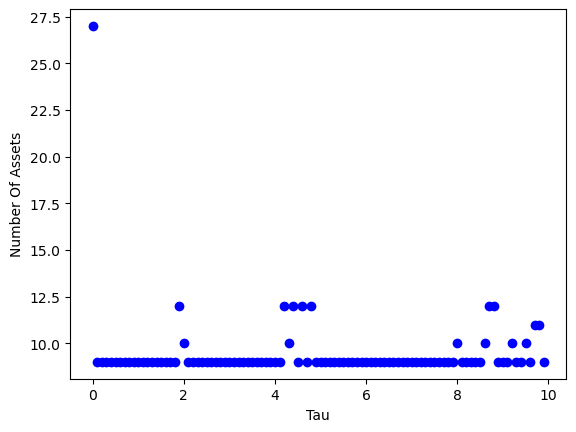

In [ ]:
tau_range: list[float] = [tau / 10 for tau in range(100)]

dummy: list[np.array] = [minimum_variance_with_regularization(data, min_expected_return=0.1, tau=tau)[0] for tau in tau_range]

number_of_assets: list[int] = []
for run in dummy:
    number_of_assets.append(sum([1 for b in run if b > 0.0001]))
    
plt.scatter(tau_range, number_of_assets, color='b')
plt.xlabel('Tau')
plt.ylabel('Number Of Assets')

TODO's
<ul>
    <li>Implement the functions above not for the maximum sharpe ratio portfolios</li>
    <li>Implement a function to simulate the performance of the portfolio over time including rebalancing every month/year?</li>
    <li>Compare the performance of the portfolio including regularization with the performance of the portfolios without</li>
    <li>Implement the 1/N portfolio</li>
</ul>